# Defining the visual vocabulary

In [1]:
import cv2 as cv
import numpy as np
import os
import sys

from sklearn.model_selection import train_test_split
from vocabulary import Vocabulary, open_image, draw_keypoints

In [2]:
dataset_dir = os.path.join('..', 'data')
# dataset_limit = 100 # -> debug purposes

# Define classes for each image
img_class = []
with open('multiclass.csv') as img_classes:
    next(img_classes)
    img_class = sorted(map(lambda line: line.strip().split(','), img_classes.readlines()))

classes = [data[1] for data in img_class] # [:dataset_limit] # -> debug purposes

# Get relative paths for the images on the dataset directory
images = [os.path.join(dataset_dir, image) for image in sorted(os.listdir(dataset_dir))] # [:dataset_limit] # -> debug purposes
train_images, test_images, train_classes, test_classes = train_test_split(images, classes, test_size=0.33, random_state=42)

# Create vocabulary
n_words = 20

print(f'Creating vocabulary with {n_words} words')
sys.stdout.flush()
vocabulary = Vocabulary(n_words)

# Find keypoints for the vocabulary
vocabulary.train(train_images)

print(f'Vocabulary dimensions: {len(vocabulary.vocabulary.shape)}') 

Creating vocabulary with 20 words
100%|██████████| 14798/14798 [11:24<00:00, 21.62it/s]
Stacking descriptors

100%|██████████| 14797/14797 [2:10:18<00:00,  1.89it/s]
Computing clusters...
Done!
Vocabulary dimensions: 2


Processing first image...


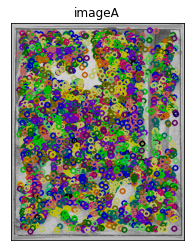

In [3]:
# Draw keypoints for the first image
query_image = train_images[0]

print('Processing first image...')
img_a = open_image(query_image)
if img_a is not None:
    detector = cv.BRISK_create(thresh=20)
    k, d = detector.detectAndCompute(img_a, None)
    words = []
    for i in range(d.shape[0]):
        words.append(vocabulary.which_word(d[i, :]))
    draw_keypoints('imageA', img_a, k, words)

# Training the Bag of Words vocabulary

In [4]:
# Perform Vector Quantization to represent the histogram of features as a vector
# Vector Quantization assigns codes from a code book to observations
from scipy.cluster.vq import vq

img_features = np.zeros((len(train_images), n_words), 'float32')
for i in range(len(train_images)):
    words, distance = vq(vocabulary.descriptor_list[i][1], vocabulary.vocabulary)
    for word in words:
        img_features[i][word] += 1

In [5]:
# Scale the words (normalization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(img_features)
img_features = scaler.transform(img_features)

In [6]:
# Train Support Vector Classification model to discriminate vectors
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=50000) # 50000 iterations for better odds of converging
svc.fit(img_features, np.array(train_classes))

LinearSVC(max_iter=50000)

# Validating Bag of Words model

In [7]:
print(f'Creating vocabulary with {n_words} words')
sys.stdout.flush()
test_vocabulary = Vocabulary(n_words)

# Find keypoints for the test vocabulary
test_vocabulary.train_without_clustering(test_images)

Creating vocabulary with 20 words
100%|██████████| 7289/7289 [05:42<00:00, 21.27it/s]


In [8]:
# Perform Vector Quantization to represent the histogram of features as a vector
# Vector Quantization assigns codes from a code book to observations
test_img_features = np.zeros((len(test_images), n_words), 'float32')
for i in range(len(test_images)):
    words, distance = vq(test_vocabulary.descriptor_list[i][1], vocabulary.vocabulary)
    for word in words:
        test_img_features[i][word] += 1

In [9]:
# Scale the words (normalization)
test_img_features = scaler.transform(test_img_features)

In [10]:
# Perform predictions and report predicted classes
predictions = svc.predict(test_img_features)

print('test_class = ', test_classes[:20])
print('prediction = ', predictions[:20])


test_class =  ['51', '51', '13', '13', '33', '13', '13', '51', '51', '51', '13', '13', '70', '51', '51', '51', '51', '51', '13', '55']
prediction =  ['51' '51' '51' '51' '13' '13' '13' '13' '13' '51' '13' '13' '13' '13'
 '13' '13' '13' '13' '13' '51']


distinct_test_classes =  ['51', '13', '33', '70', '55', '25', '58', '14', '29', '65', '32', '45', '23', '60', '35', '18', '24', '44', '41', '42', '40', '26', '69', '15', '66', '22', '59', '9', '1', '27', '49', '61', '0', '12', '46', '10', '28', '16', '43', '48', '50', '52', '54', '2', '17', '38', '56', '67', '64', '62']
nr of distinct_test_classes =  50
accuracy =  0.4781177116202497
Confusion matrix without normalization
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Normalized confusion matrix
[[0.66666667 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.    

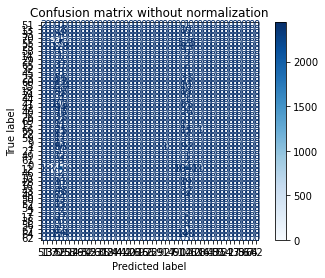

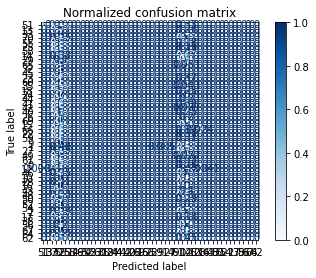

In [27]:
# Metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Confusion Matrix
from sklearn.metrics import accuracy_score, plot_confusion_matrix

distinct_test_classes = list(dict.fromkeys(test_classes))
print('distinct_test_classes = ', distinct_test_classes)
print('nr of distinct_test_classes = ', len(distinct_test_classes))
accuracy = accuracy_score(test_classes, predictions)
print('accuracy = ', accuracy)
titles_options = [("Confusion matrix without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    confusion = plot_confusion_matrix(svc, test_img_features, test_classes,
                                    display_labels=distinct_test_classes,
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)

    confusion.ax_.set_title(title)
    print(title)
    print(confusion.confusion_matrix)
plt.show()